In [22]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import Model, load_model
from keras import optimizers
import numpy as np
import shap
import keras.backend as K
import json
import split_folders
import urllib

from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, merge, Reshape, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras import backend as K

from sklearn.metrics import log_loss

from custom_layers.scale_layer import Scale

from load_cifar10 import load_cifar10_data

import sys
sys.setrecursionlimit(3000)

In [2]:
split_folders.ratio('data/', output="output", seed=1337, ratio=(.8, .2))

In [29]:
urllib.request.urlretrieve("https://github.com/adamcasson/resnet152/releases/download/v0.1/resnet152_weights_tf.h5", "resnet152_weights_tf.h5")                     

('resnet152_weights_tf.h5', <http.client.HTTPMessage at 0x7efc85230978>)

In [ ]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    '''The identity_block is the block that has no conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    '''
    eps = 1.1e-5
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    scale_name_base = 'scale' + str(stage) + block + '_branch'

    x = Convolution2D(nb_filter1, 1, 1, name=conv_name_base + '2a', bias=False)(input_tensor)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Scale(axis=bn_axis, name=scale_name_base + '2a')(x)
    x = Activation('relu', name=conv_name_base + '2a_relu')(x)

    x = ZeroPadding2D((1, 1), name=conv_name_base + '2b_zeropadding')(x)
    x = Convolution2D(nb_filter2, kernel_size, kernel_size,
                      name=conv_name_base + '2b', bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Scale(axis=bn_axis, name=scale_name_base + '2b')(x)
    x = Activation('relu', name=conv_name_base + '2b_relu')(x)

    x = Convolution2D(nb_filter3, 1, 1, name=conv_name_base + '2c', bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '2c')(x)
    x = Scale(axis=bn_axis, name=scale_name_base + '2c')(x)

    x = merge([x, input_tensor], mode='sum', name='res' + str(stage) + block)
    x = Activation('relu', name='res' + str(stage) + block + '_relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    '''conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    Note that from stage 3, the first conv layer at main path is with subsample=(2,2)
    And the shortcut should have subsample=(2,2) as well
    '''
    eps = 1.1e-5
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    scale_name_base = 'scale' + str(stage) + block + '_branch'

    x = Convolution2D(nb_filter1, 1, 1, subsample=strides,
                      name=conv_name_base + '2a', bias=False)(input_tensor)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Scale(axis=bn_axis, name=scale_name_base + '2a')(x)
    x = Activation('relu', name=conv_name_base + '2a_relu')(x)

    x = ZeroPadding2D((1, 1), name=conv_name_base + '2b_zeropadding')(x)
    x = Convolution2D(nb_filter2, kernel_size, kernel_size,
                      name=conv_name_base + '2b', bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Scale(axis=bn_axis, name=scale_name_base + '2b')(x)
    x = Activation('relu', name=conv_name_base + '2b_relu')(x)

    x = Convolution2D(nb_filter3, 1, 1, name=conv_name_base + '2c', bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '2c')(x)
    x = Scale(axis=bn_axis, name=scale_name_base + '2c')(x)

    shortcut = Convolution2D(nb_filter3, 1, 1, subsample=strides,
                             name=conv_name_base + '1', bias=False)(input_tensor)
    shortcut = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '1')(shortcut)
    shortcut = Scale(axis=bn_axis, name=scale_name_base + '1')(shortcut)

    x = merge([x, shortcut], mode='sum', name='res' + str(stage) + block)
    x = Activation('relu', name='res' + str(stage) + block + '_relu')(x)
    return x

def resnet152_model(img_rows, img_cols, color_type=1, num_classes=None):
    """
    Resnet 152 Model for Keras
    Model Schema and layer naming follow that of the original Caffe implementation
    https://github.com/KaimingHe/deep-residual-networks
    ImageNet Pretrained Weights 
    Theano: https://drive.google.com/file/d/0Byy2AcGyEVxfZHhUT3lWVWxRN28/view?usp=sharing
    TensorFlow: https://drive.google.com/file/d/0Byy2AcGyEVxfeXExMzNNOHpEODg/view?usp=sharing
    Parameters:
      img_rows, img_cols - resolution of inputs
      channel - 1 for grayscale, 3 for color 
      num_classes - number of class labels for our classification task
    """
    eps = 1.1e-5

    # Handle Dimension Ordering for different backends
    global bn_axis
    if K.image_dim_ordering() == 'tf':
      bn_axis = 3
      img_input = Input(shape=(img_rows, img_cols, color_type), name='data')
    else:
      bn_axis = 1
      img_input = Input(shape=(color_type, img_rows, img_cols), name='data')

    x = ZeroPadding2D((3, 3), name='conv1_zeropadding')(img_input)
    x = Convolution2D(64, 7, 7, subsample=(2, 2), name='conv1', bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name='bn_conv1')(x)
    x = Scale(axis=bn_axis, name='scale_conv1')(x)
    x = Activation('relu', name='conv1_relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), name='pool1')(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    for i in range(1,8):
      x = identity_block(x, 3, [128, 128, 512], stage=3, block='b'+str(i))

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    for i in range(1,36):
      x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b'+str(i))

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    x_fc = AveragePooling2D((7, 7), name='avg_pool')(x)
    x_fc = Flatten()(x_fc)
    x_fc = Dense(1000, activation='softmax', name='fc1000')(x_fc)

    model = Model(img_input, x_fc)

    if K.image_dim_ordering() == 'th':
      # Use pre-trained weights for Theano backend
      weights_path = 'imagenet_models/resnet152_weights_th.h5'
    else:
      # Use pre-trained weights for Tensorflow backend
      weights_path = 'imagenet_models/resnet152_weights_tf.h5'

    model.load_weights(weights_path, by_name=True)

    # Truncate and replace softmax layer for transfer learning
    # Cannot use model.layers.pop() since model is not of Sequential() type
    # The method below works since pre-trained weights are stored in layers but not in the model
    x_newfc = AveragePooling2D((7, 7), name='avg_pool')(x)
    x_newfc = Flatten()(x_newfc)
    x_newfc = Dense(num_classes, activation='softmax', name='fc8')(x_newfc)

    model = Model(img_input, x_newfc)

    # Learning rate is changed to 0.001
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

if __name__ == '__main__':

    # Example to fine-tune on 3000 samples from Cifar10

    img_rows, img_cols = 224, 224 # Resolution of inputs
    channel = 3
    num_classes = 10 
    batch_size = 8
    nb_epoch = 10

    # Load Cifar10 data. Please implement your own load_data() module for your own dataset
    X_train, Y_train, X_valid, Y_valid = load_cifar10_data(img_rows, img_cols)

    # Load our model
    model = resnet152_model(img_rows, img_cols, channel, num_classes)

    # Start Fine-tuning
    model.fit(X_train, Y_train,
              batch_size=batch_size,
              nb_epoch=nb_epoch,
              shuffle=True,
              verbose=1,
              validation_data=(X_valid, Y_valid),
              )

    # Make predictions
    predictions_valid = model.predict(X_valid, batch_size=batch_size, verbose=1)

    # Cross-entropy loss score

In [3]:
target_size = 300

Instructions for updating:
Colocations handled automatically by placer.
553467904/553467096 [==============================] - 6s 0us/step


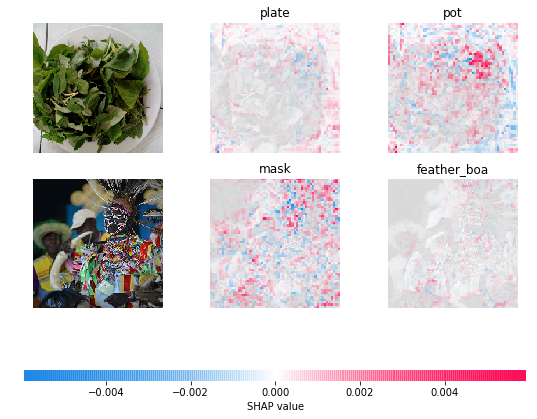

In [4]:
# load pre-trained model and choose two images to explain
model = VGG16(weights='imagenet', include_top=True) ## CHANGE INCLUDE TOP TO FALSE
X,y = shap.datasets.imagenet50()
to_explain = X[[6,7]]

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
e = shap.GradientExplainer((model.layers[7].input, model.layers[-1].output), map2layer(preprocess_input(X.copy()), 7))
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)

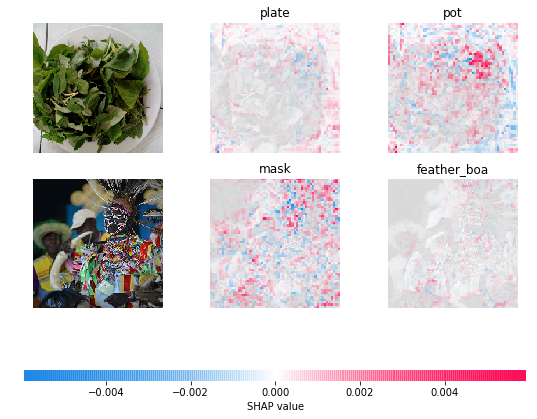

In [5]:
shap.image_plot(shap_values, to_explain, index_names)

In [6]:
img_width = target_size
img_height = target_size
batch_size =16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling (we do not want to modify the testing data)
test_datagen = ImageDataGenerator(rescale=1. / 255)


# The generator object. 
train_generator = train_datagen.flow_from_directory(
    'output/train',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    'output/val',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 3065 images belonging to 14 classes.
Found 774 images belonging to 14 classes.


In [7]:
def add_new_last_layer(base_model, nb_classes=14):
    """Add last layer to the convnet
    Args:
    base_model: keras model excluding top
    nb_classes: # of classes
    Returns:
    new keras model with last layer
    """
    # Get the output shape of the models last layer
    x = base_model.output
    # Convert final MxNxC tensor output into a 1xC tensor where C is the # of channels.
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x) 
    x = Dropout(.5)(x)
    predictions = Dense(nb_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [8]:
# This will freeze the weights on all the layers except for our new dense layer
def setup_to_transfer_learn(model, base_model):
  """Freeze all layers and compile the model"""
  for layer in base_model.layers:
    layer.trainable = False
  model.compile(optimizer=optimizers.SGD(lr=0.0001, momentum=0.9),    
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

In [9]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(target_size,target_size,3))

tran_model = add_new_last_layer(base_model)
setup_to_transfer_learn(tran_model,base_model)

58892288/58889256 [==============================] - 1s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
tran_model = load_model('model.h5')

In [21]:
nb_epoch = 3

tran_model.fit_generator(
    train_generator,
    epochs=nb_epoch,
    steps_per_epoch=100,
    validation_data=validation_generator,
    validation_steps=10)

Epoch 1/3
  1/100 [..............................] - ETA: 1:51 - loss: 1.9463 - acc: 0.4375

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


 39/100 [==========>...................] - ETA: 33s - loss: 2.0399 - acc: 0.3670

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 5. Skipping tag 42036
  " Skipping tag %s" % (size, len(data), tag))


100/100 [==============================] - 58s 582ms/step - loss: 2.0341 - acc: 0.3871 - val_loss: 2.0475 - val_acc: 0.4067
Epoch 2/3
100/100 [==============================] - 54s 543ms/step - loss: 2.0354 - acc: 0.3888 - val_loss: 2.1066 - val_acc: 0.3500
Epoch 3/3
100/100 [==============================] - 53s 531ms/step - loss: 2.0299 - acc: 0.3807 - val_loss: 2.0297 - val_acc: 0.4125


In [11]:
img = load_img('output/val/boxer/1485179194-boxer-dog-portrait.jpg',target_size=(target_size,target_size) )
img = img_to_array(img)
img = img.reshape((1,) + img.shape)
img.shape

(1, 300, 300, 3)

In [12]:
pred = tran_model.predict(img)
pred

array([[3.2222651e-02, 3.0633018e-07, 9.6411085e-01, 2.3087945e-10,
        8.5411489e-04, 8.7056833e-06, 2.3637783e-06, 2.6868116e-03,
        4.6161563e-06, 2.5009212e-09, 2.8977485e-07, 9.4590450e-06,
        7.2485091e-05, 2.7384598e-05]], dtype=float32)

In [13]:
np.round(pred, decimals=3)

array([[0.032, 0.   , 0.964, 0.   , 0.001, 0.   , 0.   , 0.003, 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   ]], dtype=float32)

In [14]:
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
predictions

['bernese_mountain_dog']

In [15]:
# load pre-trained model and choose two images to explain
# model = VGG16(weights='imagenet', include_top=True) ## CHANGE INCLUDE TOP TO FALSE
model = tran_model
# X,y = shap.datasets.imagenet50()
img = load_img('output/val/boxer/1485179194-boxer-dog-portrait.jpg',target_size=(224,224) )
img = img_to_array(img)
img = img.reshape((1,) + img.shape)
to_explain = img
X = img

# # load the ImageNet class names
# url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
# fname = shap.datasets.cache(url)
# with open(fname) as f:
#     class_names = json.load(f)
class_names = labels

# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)

e = shap.GradientExplainer((model.layers[7].input, model.layers[-1].output), map2layer(preprocess_input(X.copy()), 7))
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)

ValueError: Cannot feed value of shape (1, 224, 224, 3) for Tensor 'input_2:0', which has shape '(?, 300, 300, 3)'

In [ ]:
K.get_session().run(model.layers[layer].input, feed_dict)